In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")

import time
import timeit

import scipy.stats 
import pandas as pd
import pymc as pm

import re
import numpy as np
from datetime import datetime
from datetime import timedelta as td

/Users/peterharrington/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/peterharrington/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### Grab the list of files in our data set
- Data set is for Soybeans futures
- Each file is one day of trading

In [7]:
import os
minuteDirectory = "../data/min/"
minuteFiles = np.array(os.listdir(minuteDirectory))
print "Directory: ", minuteFiles[0:5]

Directory:  ['ZS201405_20140421.csv' 'ZS201405_20140422.csv' 'ZS201405_20140423.csv'
 'ZS201405_20140424.csv' 'ZS201405_20140425.csv']


### A few functions to deal with simple file transactions
- We are using Pandas in the model evaluation, but having a simple genfromtxt call is useful for data analysis

In [8]:
def getFullFileName(minuteDirectory, minuteFile):
    return minuteDirectory + "/" + minuteFile
    
dateconv = lambda x: datetime.strptime(x, "%Y%m%d %H:%M:%S")
print "Date: ", dateconv("20160114  17:00:00")

def readMinuteFile(minuteFileName):
    names=("date","open","high","low","close","volume","adjclose")
    types=("|S18", float, float, float, float, int, float)

    data = np.genfromtxt(minuteFileName, delimiter=",", skip_header=1, names=names, dtype=None, converters={'date': dateconv})
    return data

Date:  2016-01-14 17:00:00


#### Function to get mean valuation
- Returns mean of open, close, difference of high vs. low

In [9]:
def getMeanValuation(m_data):
    return (np.mean(m_data["open"]), np.mean(m_data["close"]), np.mean(np.absolute(m_data["high"] - m_data["low"])))
minuteFile = getFullFileName(minuteDirectory, minuteFiles[0])
m_data = readMinuteFile(minuteFile)

print "m_data: ", np.concatenate((m_data["close"], m_data["open"]), axis=0)

m_open, m_close, m_diff = getMeanValuation(m_data)
print "m_open:  ", m_open
print "m_close: ", m_close
print "m_diff:  ", m_diff

m_data:  [ 1517.5   1517.    1517.5  ...,  1496.5   1496.5   1498.25]
m_open:   1507.64333333
m_close:  1507.63285714
m_diff:   0.324285714286


In [10]:
avg_data = np.empty(minuteFiles.shape[0])
for i in np.arange(minuteFiles.shape[0]):
    minuteFile = minuteFiles[i]
    minuteData = readMinuteFile(getFullFileName(minuteDirectory, minuteFile))
    m_open, m_close, m_diff = getMeanValuation(minuteData)
    if((i % 100) == 0):
        print "Read ", i, " files -- currently @ ", minuteFile
    avg_data[i] = m_open

Read  0  files -- currently @  ZS201405_20140421.csv
Read  100  files -- currently @  ZS201409_20140908.csv
Read  200  files -- currently @  ZS201503_20150128.csv
Read  300  files -- currently @  ZS201507_20150622.csv
Read  400  files -- currently @  ZS201511_20151110.csv
Read  500  files -- currently @  ZS201605_20160406.csv


### Let's look at the valuation of the entire range of our data
- Data fluxuates quite a bit
- Data is generally trending downward during our overall range

# AM 207 Final Project 

# Evolving Trading Bots
## Peter Harrington and Bryan Jeffrey

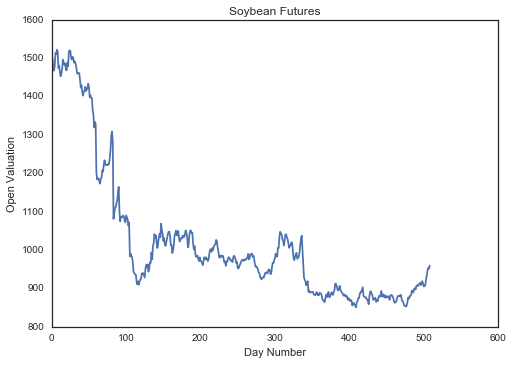

In [18]:
x = np.arange(avg_data.shape[0])
plt.plot(x, avg_data)
plt.xlabel('Day Number')
plt.ylabel('Open Valuation')
plt.title('Soybean Futures')
plt.show()

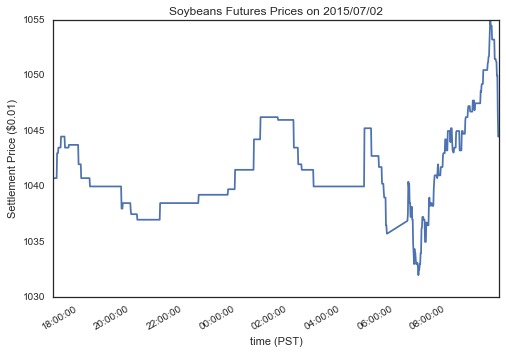

In [4]:
DATA_DIR = "/Users/peterharrington/Documents/GitHub/evolvingtradingbots/data/min/"

def plot_single_day():
    """Choose a day's data and plot it"""
    df = pd.read_csv(DATA_DIR + "ZS201507_20150702.csv", index_col='Date', parse_dates=True, na_values=['nan'])
    df["Adj Close"].plot()
    plt.xlabel("time (PST)")
    plt.ylabel("Settlement Price ($0.01)")
    plt.title("Soybeans Futures Prices on 2015/07/02")
    plt.show()
    
plot_single_day()

# Mean Reversion

$$x_{t+1} = x_t + k(\mu_b -x_t) + \epsilon$$

- We want to find the best k, and $\mu_b$  
- This tells us how to get into a trade
- For simplicity we will fix the way to "get out of a trade"

# Walk Forward Testing

![alt text](walk_for.png "Title")

### Generate a simple naive score
- Let's simply take the difference between open at the start of our data and close at the end
- This will represent the value if someone were to have invested at the start, and divested at the end of the range
- This provides us an idea of the overall trend of the market to allow us to differentiate against our optimization strategies

In [12]:
def naiveScore(minuteFiles):
    minuteFile = minuteFiles[0]
    minuteData = readMinuteFile(getFullFileName(minuteDirectory, minuteFile))
    initialValuation = minuteData["open"][0]
    
    minuteFile = minuteFiles[minuteFiles.shape[0] - 1]
    minuteData = readMinuteFile(getFullFileName(minuteDirectory, minuteFile))
    finalValuation = minuteData["close"][minuteData.shape[0] - 1]

    difference = initialValuation - finalValuation
    print "initial valuation:  ", initialValuation
    print "final valuation:    ", finalValuation
    print "difference:         ", (initialValuation - finalValuation)
    return difference

initialInvestment = 10000
print "Naive Score: ", naiveScore(minuteFiles)

Naive Score:  initial valuation:   1515.0
final valuation:     954.25
difference:          560.75
560.75


### Our scoring function
- We use walk-forward analysis as described in our paper to score over time
- We apply our mean reversion model over the specified day
- This function is used by both the Genetic Algorithms and Simulated Annealing implementations

In [18]:

from MRSingleDay import MRSingleDay

fileName = "ZS201605_20160314.csv"
scalingParameter = 0.8
meanDays = 4
profitTarget = 2
stopLoss = -5


d = MRSingleDay(fileName, scalingParameter, meanDays, profitTarget, stopLoss)
ro = d.calc_returns()
print "winning: {}, loosing: {}, profit: {}".format(ro.num_win, ro.num_loose, ro.cum_ret)

winning: 3, loosing: 0, profit: 6.875


In [14]:
from FileIndexer import FileIndexer
from datetime import datetime
from datetime import timedelta as td

fileIndexer = FileIndexer("../data/min")
startDate = datetime(2016,4,14)
endDate = datetime(2016,4,18)
filesToUse = fileIndexer.getFilesForPeriod(startDate, endDate)
print "Files To Use: ", filesToUse


Files To Use:  ['ZS201605_20160414.csv' 'ZS201605_20160415.csv' 'ZS201605_20160418.csv']


Simulated Annealing Algorithm: 
1.	Select a new point to evaluate
2.	Calculate the difference in energy between the new point and the old
3.	If the energy is higher, accept.  Else probabilistically accept based on energy and temperature.
4.	Every K iterations adjust the temperature lower based on the thermostat parameter.
5.	Every N iterations ‘re-heat’, increasing the temperature to make the acceptance probability higher.


In [15]:
def modifyParameters(scalingParameter, meanDays):
    modScalingParameter = np.max((scalingParameter + np.random.normal()), 0.1)
    modMeanDays = np.maximum((meanDays + np.random.randint(-1, 2)), 1)
    return (modScalingParameter, modMeanDays)

def simulatedAnnealing(currentFileName, initialMeanDays, initialScalingParameter, profitTarget, stopLoss, initTemp, thermostat, maxIter, reannealing):
    scores = []
    maxScores = []
    temperature = initTemp
    it = 0
    
    print "Current File Name: ", currentFileName
    
    scalingParameter = initialScalingParameter
    meanDays = initialMeanDays
    
    d = MRSingleDay(currentFileName, scalingParameter, meanDays, profitTarget, stopLoss)

    ro = d.calc_returns()
    prevE = ro.cum_ret
    maxScore = prevE
    maxParams = (initialScalingParameter, meanDays)
    
    numBaseSteps = 2
    numIterations = 0
    while(it >= 0):
        L = np.max((np.floor(temperature * numBaseSteps).astype(int),1))
        proposedScaling, proposedMean = modifyParameters(scalingParameter, meanDays)
        d = MRSingleDay(currentFileName, proposedScaling, proposedMean, profitTarget, stopLoss)
        ro = d.calc_returns()
        newE = ro.cum_ret
        deltaE = newE - prevE
        u = np.random.uniform()
        prob = np.exp( -deltaE/temperature)

        # If we're heading up (in this case higher score better), keep
        if(newE > prevE):
            scalingParameter = proposedScaling
            meanDays = proposedMean
            prevE = newE
            it += 1
        elif u < prob:
            scalingParameter = proposedScaling
            meanDays = proposedMean
            prevE = newE
            it += 1
            
        if(prevE > maxScore):
            maxScore = prevE
            maxParams = (scalingParameter, meanDays)
            maxScores.append(prevE)
            print "Max Score Increase ", numIterations, " max score: ", maxScore, " parameters: ", maxParams
        
        numIterations += 1
        
        if(it % reannealing) == 0:
            temperature = thermostat * temperature
            
            # reheat
            if(temperature < 0.01):
                temperature = 1
                scalingParameter, meanDays = maxParams
                prevE = maxScore
                
        if numIterations > maxIter:
            print "Ending @ ", numIterations, " with max parameters: ", maxParams
            break
            
    return maxScore, maxScores, maxParams



def runSimulatedAnnealing(fileName):
    initialMeanDays = 4
    initialScalingParameter = 0.8
    profitTarget = 2
    stopLoss = -5
    initTemp = 2
    thermostat = 0.95
    maxIter = 30
    reannealing = 10
    maxScore, maxScores, maxParams = simulatedAnnealing(fileName, initialMeanDays, initialScalingParameter, profitTarget, stopLoss, initTemp, thermostat, maxIter, reannealing)        
    return maxScore, maxParams[0], maxParams[1]

In [23]:
fIndexer = FileIndexer("../data/min/")
startDate = datetime(2014,4,1)
endDate = datetime(2016,1,1)
fileList = fIndexer.getFilesForPeriod(startDate, endDate)
#print "File List: ", fileList

results = np.empty((fileList.shape[0], 3))
# For purposes of iPython Notebook example compute first few days only.
#for i in np.arange(fileList.shape[0]):
for i in np.arange(4):
    maxScore, scalingParameter, meanObs = runSimulatedAnnealing(fileList[i])
    results[i][0] = scalingParameter
    results[i][1] = meanObs
    results[i][2] = maxScore
    print "Computed Result for ", fileList[i], " -- ", results[i][0], ", ", results[i][1], " -- max score: ", results[i][2]

Current File Name:  ZS201405_20140421.csv
Max Score Increase  0  max score:  -22.975  parameters:  (1.5215890399657463, 5)
Max Score Increase  1  max score:  -11.2  parameters:  (3.5144835394482405, 6)
Max Score Increase  4  max score:  -6.975  parameters:  (4.5416088239867092, 7)
Max Score Increase  12  max score:  -0.1  parameters:  (6.6323986420447643, 5)
Max Score Increase  13  max score:  2.475  parameters:  (5.32769308945866, 4)
Max Score Increase  15  max score:  5.0  parameters:  (6.3573778538206964, 2)
Max Score Increase  21  max score:  7.175  parameters:  (4.0276594395027576, 2)
Ending @  31  with max parameters:  (4.0276594395027576, 2)
Computed Result for  ZS201405_20140421.csv  --  4.0276594395 ,  2.0  -- max score:  7.175
Current File Name:  ZS201405_20140422.csv
Max Score Increase  0  max score:  5.925  parameters:  (2.4967759227604982, 3)
Max Score Increase  2  max score:  7.3  parameters:  (2.03322015636344, 2)
Ending @  31  with max parameters:  (2.03322015636344, 2)

### Genetic Algorithm:
for each time period:
- Generate N random individuals (or start from previous day's survivors)
  - for G generations:
    - evaluate performance (fitness)
    - those with high fitness can reproduce (crossover)
    - apply random mutations to children with mutation rate


In [21]:
from MRSingleDay import MRSingleDay
from FileIndexer import FileIndexer
import numpy as np
from datetime import datetime


NUM_GENERATIONS = 5
POP_SIZE = 6  # population size
SURVIVAL_RATE = 0.5
MUTATION_RATE = 0.4

PROFIT_TARGET = 2
STOP_LOSS = -5

def crossover(ina, inb):
    """Returns a crossover pair of ina and inb"""
    return [(ina[0], inb[1]), (inb[0], ina[1])]


def mutate(in_tup):
    """ Code borrowed from this project's SimulatedAnnealing modifyParameters"""
    mod_scaling_parameter = np.max((in_tup[0] + np.random.normal()), 0.1)
    mod_mean_days = np.maximum((in_tup[1] + np.random.randint(-1, 2)), 1)
    return (mod_scaling_parameter, mod_mean_days)


def reproduce_mutate(sorted_fitness, solutions):
    """allows the fittest to reproduce, also applies mutation"""
    ret_solns = []
    # those with high fitness can reproduce (crossover)
    print sorted_fitness
    reproducing_size = int(POP_SIZE * SURVIVAL_RATE)
    index = 0
    for k in range(reproducing_size):
        for j in range(k, reproducing_size):
            if k != j:
                gene_a = solutions[sorted_fitness[k]]
                gene_b = solutions[sorted_fitness[j]]
                ret_solns.extend(crossover(gene_a, gene_b))

    # apply random mutations to children
    mutation_rvs = np.random.uniform(0, 1, POP_SIZE)
    for m in np.flatnonzero(mutation_rvs < MUTATION_RATE):
        print "mutation happended!"
        ret_solns[m] = mutate(ret_solns[m])

    return ret_solns


def single_period_ga(fn, solns, fitness_ftn):
    """Perform genetic algorithm for a single day"""
    best_soln = None
    best_fitness = float('-inf')
    for g in range(NUM_GENERATIONS):
        print "generation: ",g
        fitness = np.zeros(POP_SIZE)
        for i, sol in enumerate(solns):# iterate over all the members of the population
            # evaluate performance (fitness)
            d = MRSingleDay(fn, sol[0], sol[1], PROFIT_TARGET, STOP_LOSS)
            ro = d.calc_returns()
            fitness[i] = fitness_ftn(ro)
            print sol, i, fitness[i]
        sorted_fitness = np.argsort(fitness)[::-1]

        if fitness[sorted_fitness[0]] > best_fitness:  # find the best solution
            best_fitness = fitness[sorted_fitness[0]]
            best_soln = solns[sorted_fitness[0]]

        solns = reproduce_mutate(sorted_fitness, solns)

    return best_fitness, best_soln, solns


def init_solns():
    return [(2.033, 3), (-2.397, 5), (-0.940, 7), (-1.563, 4), (2.067, 9), (0.817, 2)]

def cum_ret_fitness(ro_in):
    """Returns the cumulative returns from a trade result object"""
    return ro_in.cum_ret

In [22]:
# for each day:
# Generate N random individuals (or start from previous day's survivors)

initial_solutions = [(2.033, 3), (-2.397, 5), (-0.940, 7), (-1.563, 4), (2.067, 9), (0.817, 2)]
single_period_ga("ZS201407_20140521.csv", initial_solutions, cum_ret_fitness)

generation:  0
(2.033, 3) 0 6.65
(-2.397, 5) 1 31.125
(-0.94, 7) 2 -11.025
(-1.563, 4) 3 15.475
(2.067, 9) 4 -28.05
(0.817, 2) 5 -21.1
[1 3 0 2 5 4]
generation:  1
(-2.397, 4) 0 31.125
(-1.563, 5) 1 -0.075
(-2.397, 3) 2 25.275
(2.033, 5) 3 -9.525
(-1.563, 3) 4 39.925
(2.033, 4) 5 -8.625
[4 0 2 1 5 3]
mutation happended!
mutation happended!
mutation happended!
mutation happended!
generation:  2
(-2.0874897128407706, 3) 0 31.125
(-2.397, 3) 1 25.275
(-1.6392373591757936, 3) 2 31.125
(-2.2597089890894884, 4) 3 31.125
(-2.0715860239464559, 3) 4 31.125
(-2.397, 4) 5 31.125
[5 4 3 2 0 1]
mutation happended!
mutation happended!
mutation happended!
generation:  3
(-2.397, 3) 0 25.275
(-2.0715860239464559, 4) 1 31.125
(-3.6549006204206531, 5) 2 31.125
(-1.504942904121799, 3) 3 39.925
(-2.0715860239464559, 4) 4 31.125
(-1.7936768476838221, 3) 5 31.125
[3 5 4 2 1 0]
generation:  4
(-1.504942904121799, 3) 0 39.925
(-1.7936768476838221, 3) 1 31.125
(-1.504942904121799, 4) 2 15.475
(-2.0715860239464

(39.924999999999955,
 (-1.563, 3),
 [(-1.7936768476838221, 3),
  (-1.504942904121799, 4),
  (-0.27474638016162722, 4),
  (-1.8300689933719672, 3),
  (-1.504942904121799, 3),
  (-2.0715860239464559, 3)])

# Results

## Comparing Optimization Techniques 

| |Naïve Approach | Simulated Annealing  | Genetic Algorithm 
| ------------- |:-------------:|:-------------:|-----:|
|In sample Cumulative Returns |N/A |5488.65 |2620.675 |
|Out of sample Cumulative Returns | -560.75 |219.075 |-20.3| 


## Other Fitness Functions

 
| |Out of Sample Cum Returns 
| ------------- |-----:|
|Cumulative Return | 219.1 | 
|Win Ratio | 74.8 |
|Average Profit Per Trade | 307.3 | 


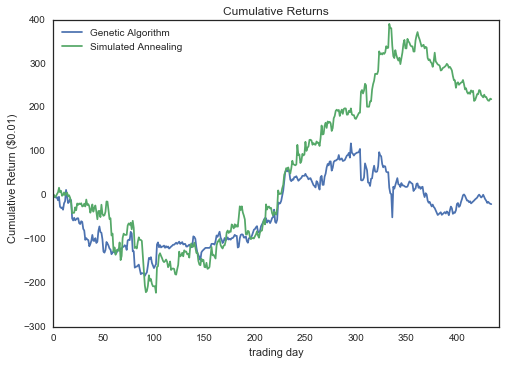

In [12]:
CODE_DIR = "/Users/peterharrington/Documents/GitHub/evolvingtradingbots/code/"
def plot_cum_results2():
    df = pd.read_csv(CODE_DIR + "SA_GA_cum.csv")

    df["Genetic Algorithm"].plot(legend=True)
    df["Simulated Annealing"].plot(legend=True)
    plt.xlabel("trading day")
    plt.ylabel("Cumulative Return ($0.01)   ")
    plt.title("Cumulative Returns")
    plt.show()
    
plot_cum_results2()